In [ ]:
from google.colab.patches import cv2_imshow
from google.colab import drive
import numpy
import sys
import cv2
import tqdm

# Import file to Drive 

drive.mount('/content/drive')
data_file = "/content/drive/My Drive/"
Img_file = data_file + "Particules.jpg"

# for local Images 

# Img_file = "path of image" 
# change Function cv2_imshow(img) to cv2.imshow("window",img)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 10/10 [00:19<00:00,  1.91s/it]
<ipython-input-33-3fd131966a85>:109: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_taken = numpy.zeros(img.shape[:2], numpy.bool)


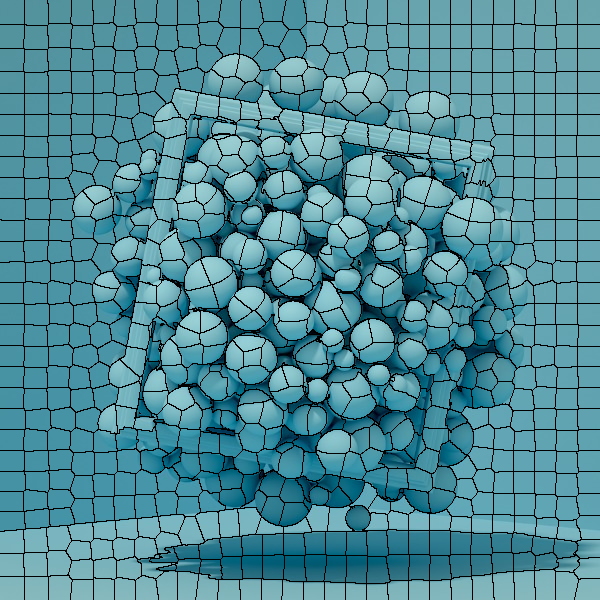

In [ ]:

import numpy
import cv2
import tqdm
import sys


##############################################################################################""

def Superpixels():
    indnp = numpy.mgrid[0:SLIC_height,0:SLIC_width].swapaxes(0,2).swapaxes(0,1)
    for i in tqdm.tqdm(range(ITERATIONS)):
        SLIC_distances = 1 * numpy.ones(img.shape[:2])
        for j in range(SLIC_centers.shape[0]):
            x_low, x_high = int(SLIC_centers[j][3] - step), int(SLIC_centers[j][3] + step)
            y_low, y_high = int(SLIC_centers[j][4] - step), int(SLIC_centers[j][4] + step)

            if x_low <= 0:
                x_low = 0
          
            if x_high > SLIC_width:
                x_high = SLIC_width
         
            if y_low <=0:
                y_low = 0
        
            if y_high > SLIC_height:
                y_high = SLIC_height
      

            cropimg = SLIC_labimg[y_low : y_high , x_low : x_high]
            color_diff = cropimg - SLIC_labimg[int(SLIC_centers[j][4]), int(SLIC_centers[j][3])]
            color_distance = numpy.sqrt(numpy.sum(numpy.square(color_diff), axis=2))

            yy, xx = numpy.ogrid[y_low : y_high, x_low : x_high]
            pixdist = ((yy-SLIC_centers[j][4])**2 + (xx-SLIC_centers[j][3])**2)**0.5

            
            dist = ((color_distance/m)**2 + (pixdist/step)**2)**0.5

            distance_crop = SLIC_distances[y_low : y_high, x_low : x_high]
            idx = dist < distance_crop
            distance_crop[idx] = dist[idx]
            SLIC_distances[y_low : y_high, x_low : x_high] = distance_crop
            SLIC_clusters[y_low : y_high, x_low : x_high][idx] = j


        for k in range(len(SLIC_centers)):
            idx = (SLIC_clusters == k)
            colornp = SLIC_labimg[idx]
            distnp = indnp[idx]
            SLIC_centers[k][0:3] = numpy.sum(colornp, axis=0)
            sumy, sumx = numpy.sum(distnp, axis=0)
            SLIC_centers[k][3:] = sumx, sumy
            SLIC_centers[k] /= numpy.sum(idx)

##############################################################################################""

def Connectivity():
    label = 0
    adj_label = 0
    lims = int(SLIC_width * SLIC_height / SLIC_centers.shape[0])
    
    new_clusters = -1 * numpy.ones(img.shape[:2]).astype(numpy.int64)
    elements = []
    for i in range(SLIC_width):
        for j in range(SLIC_height):
            if new_clusters[j, i] == -1:
                elements = []
                elements.append((j, i))
                for dx, dy in [(-1,0), (0,-1), (1,0), (0,1)]:
                    x = elements[0][1] + dx
                    y = elements[0][0] + dy
                    if (x>=0 and x < SLIC_width and 
                        y>=0 and y < SLIC_height and 
                        new_clusters[y, x] >=0):
                        adj_label = new_clusters[y, x]


            count = 1
            counter = 0
            while counter < count:
                for dx, dy in [(-1,0), (0,-1), (1,0), (0,1)]:
                    x = elements[counter][1] + dx
                    y = elements[counter][0] + dy

                    if (x>=0 and x<SLIC_width and y>=0 and y<SLIC_height):
                        if new_clusters[y, x] == -1 and SLIC_clusters[j, i] == SLIC_clusters[y, x]:
                            elements.append((y, x))
                            new_clusters[y, x] = label
                            count+=1


                counter+=1

            if (count <= lims >> 2):
                for counter in range(count):
                    new_clusters[elements[counter]] = adj_label


                label-=1


            label+=1
 

    SLIC_new_clusters = new_clusters

##############################################################################################""

def Contours(color):
    is_taken = numpy.zeros(img.shape[:2], numpy.bool)
    contours = []

    for i in range(SLIC_width):
        for j in range(SLIC_height):
            nr_p = 0
            for dx, dy in [(-1,0), (-1,-1), (0,-1), (1,-1), (1,0), (1,1), (0,1), (-1,1)]:
                x = i + dx
                y = j + dy
                if x>=0 and x < SLIC_width and y>=0 and y < SLIC_height:
                    if is_taken[y, x] == False and SLIC_clusters[j, i] != SLIC_clusters[y, x]:
                        nr_p += 1


            if nr_p >= 2:
                is_taken[j, i] = True
                contours.append([j, i])

    for i in range(len(contours)):
        img[contours[i][0], contours[i][1]] = color

##############################################################################################""

def find_low_gradient(center):
    min_grad = 1
    loc_min = center
    for i in range(center[0] - 1, center[0] + 2):
        for j in range(center[1] - 1, center[1] + 2):
            c1 = SLIC_labimg[j+1, i]
            c2 = SLIC_labimg[j, i+1]
            c3 = SLIC_labimg[j, i]
            if ((c1[0] - c3[0])**2)**0.5 + ((c2[0] - c3[0])**2)**0.5 < min_grad:
                min_grad = abs(c1[0] - c3[0]) + abs(c2[0] - c3[0])
                loc_min = [i, j]

    return loc_min

##############################################################################################""

def initiate_Cluster_Centers():
    centers = []
    for i in range(step, SLIC_width - int(step/2), step):
        for j in range(step, SLIC_height - int(step/2), step):
            nc = find_low_gradient(center=(i, j))
            color = SLIC_labimg[nc[1], nc[0]]
            center = [color[0], color[1], color[2], nc[0], nc[1]]
            centers.append(center)


    return centers

##############################################################################################""

## Global variables

# SLIC Parameters
Number_of_Superpixels = 800
m = 60

img = cv2.imread(Img_file)

step = int((img.shape[0]*img.shape[1]/Number_of_Superpixels)**0.5)

ITERATIONS = 10
SLIC_height , SLIC_width = img.shape[:2]
SLIC_labimg = cv2.cvtColor(img, cv2.COLOR_BGR2LAB).astype(numpy.float64)
SLIC_distances = 1 * numpy.ones(img.shape[:2])
SLIC_clusters = -1 * SLIC_distances
SLIC_center_counts = numpy.zeros(len(initiate_Cluster_Centers()))
SLIC_centers = numpy.array(initiate_Cluster_Centers())

## Generate superpixels by executing next functions 

Superpixels()
Connectivity()
initiate_Cluster_Centers()
# BGR COLOR of Contours 
display_contours([0,0,0])
cv2_imshow(img)


